In [1]:
import os
import re
import pickle
import requests
import warnings
from tqdm import tqdm

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud

In [3]:
from konlpy.tag import Okt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

In [4]:
warnings.filterwarnings('ignore', category=UserWarning)

# Seaborn 테마 설정
sns.set_theme(style='whitegrid')

# 한글 폰트 사용
font_path = "C:\Windows\Fonts\Hancom Gothic Bold.ttf"  # 경로 확인 후 변경 필요
font_prop = fm.FontProperties(fname=font_path)
plt.rc('font', family=font_prop.get_name())

<>:7: SyntaxWarning: invalid escape sequence '\W'
<>:7: SyntaxWarning: invalid escape sequence '\W'
C:\Users\user\AppData\Local\Temp\ipykernel_5796\3491805238.py:7: SyntaxWarning: invalid escape sequence '\W'
  font_path = "C:\Windows\Fonts\Hancom Gothic Bold.ttf"  # 경로 확인 후 변경 필요


# 훈련 데이터 셋 가져오기
- 구글 플레이 스토어에 있는 리뷰를 통한 데이터 훈련
- 평점의 1, 2, 3 -> 0 , 4, 5 -> 1로 라벨링을 설정하고 회귀분석 모델로 감정분석 진행

In [8]:
# 훈련된 모델 및 TF-IDF 벡터라이저 불러오기
with open("../data/mining/X_train.pkl", "rb") as f:
  X_train = pickle.load(f)

with open("../data/mining/y_train.pkl", "rb") as f:
  y_train = pickle.load(f)

# 커뮤니티 데이터 가져오기
- 공식홈페이지 : 12월 ~ 3월 -> 2월 ~ 3월로 분석 변경(2개월치)
- 디시인사이드 : 2월 ~ 3월까지 (2개월치)

## 공식 홈페이지 전처리

In [13]:
# 커뮤니티부터 데이터 전처리 시작
home_df = pd.read_csv("../data/dnf_homepage_content.csv").drop(columns = 'Unnamed: 0')

# 한글과 공백만 남기고 정제
home_df['content'] = home_df['content'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", regex=True).str.strip()

# 빈 문자열 처리
home_df['content'] = home_df['content'].replace('', np.nan)

# 결측치 제거
home_df = home_df.dropna(subset=['content'])

# 데이터 확인
home_df.head()

,time,num,category,nickname,title,content
0,2025-04-09,2895383,수다,타쿠쟝,"['[공통]', '★★븜하', '커뮤니티', '오픈톡방', '인원', '모집', '...",븜하 커뮤니티 오픈톡방 인원 모집 수다 정보공유 중천 나벨레이드 구인방 븜하 ...
1,2025-04-09,2924227,질문,성기사주세요,"['[공통]', '던담', '딜', '관련질문', '(1)']",새로고침 누르면 딜이 낮아졌다 높아졌다하는데 왜이런건가요
2,2025-04-09,2924226,수다,이올라,"['[공통]', '갱신되는', '카드']",나벨레이드 갱신 카드
3,2025-04-09,2924225,질문,리홍뀨,"['[공통]', '무한화서', '내일', '끝나면', '에픽무기도', '못까는건가요...",분홍색 큰거 하나만 먹으면 되는데내일 끝나면 없어지는건가요
4,2025-04-09,2924224,질문,Fiendish강유,"['[공통]', '패스', '및', '패키지', '관련', '질문', '(5)']",안녕하세요복귀 일차 뉴비입니다현재 프로스트 패키지 개와 로얄패스를 구매하여 사용중인...


In [19]:
# 공통된 데이터를 위해 데이터 통일
## 2월1일 ~ 3월31일로 필터링 필요
home_df['time'] = pd.to_datetime(home_df['time'])
filtered_home_df = home_df[(home_df['time'] >= '2025-02-01') & (home_df['time'] <= '2025-03-31')]
filtered_home_df = filtered_home_df.sort_values(by = 'time')
filtered_home_df

,time,num,category,nickname,title,content
18413,2025-02-01,2902233,수다,여디,"['[공통]', '신생', '아재', '길드', ""'행복한마을'"", '길드원', '...",안녕하세요오늘 처음 만든 신생길드 행복한마을 입니다다들 기존 오래된 길드에서 텃세에...
18175,2025-02-01,2902530,수다,무친고등어,"['[공통]', '새내기랑', '쿠폰', '교환하실분', '구함니당', '(3)']",뉴비에용 잘부탁드립니다
18176,2025-02-01,2902529,수다,Eics,"['[배틀메이지]', '겨울나기', '선배님', '구합니당']",시작한 지 얼마 안된 뉴비 도와주실 선배님 구합니당
18177,2025-02-01,2902527,수다,담담한,"['[공통]', '새내기루로', '중천', '쿠폰', '구해용!']",열심히 할게용
18178,2025-02-01,2902526,수다,그림자추격자,"['[공통]', '오', '카드', '나오긴', '하네요', '(2)']",안나오는건줄 알았지 ㅋㅋㅋㅋ
...,...,...,...,...,...,...
2151,2025-03-31,2922028,질문,호호꿀,"['[여크루세이더]', '버퍼마부', '질문좀', '드려요', '(4)']",지금 배낭지기베니부만 발라놨는데 나머지 비싼 목걸이 귀걸이 제외하면 한 천골드들던데...
2150,2025-03-31,2922029,수다,그증상이미병,"['[공통]', '종말', '1000판', '돌면', '태초', '확정드랍', '정...",근데 이렇게 말하면 또 태초 못먹어서 빡친듯 ㅋ 태초 공짜로 달라는건 양심 졌누 ㅋ...
2149,2025-03-31,2922030,수다,타격시,"['[공통]', '내일이면', '태초항아리까네요', '(1)']",어제 주만에 본캐로 태초먹어서 드디어 항아리깝니다개 모이기 전에 태거시먹는건 역시 ...
2176,2025-03-31,2922000,수다,도비S배메,"['[공통]', '도비의', '03/31', '월요일', '환요2종', '20캐릭'...",태초빔은 못봤지만트블 발키리세트에픽개 드랍했다 주


## 디시인사이드 전처리

In [ ]:
# 크롤링 데이터 로드
dc_df_1 = pd.read_csv('../data/dnf_dcinside_content_1805-.csv').drop(columns='Unnamed: 0')
dc_df_2 = pd.read_csv('../data/dnf_dcinside_progress_20250414_091423_to_page_15959.csv')

In [45]:
# 병합이 필요한데 어처피 title_num 기준으로 결측값 제거 할꺼라 겹쳐놓고 중복값 제거로 수정하자
dc_df = pd.concat([dc_df_1, dc_df_2])

# 중복값 제거
dc_df = dc_df.drop_duplicates(subset = 'title_num')

dc_df.columns = ['num', 'time', 'nickname', 'title', 'content']

In [51]:
# 한글과 공백만 남기고 정제
dc_df['content'] = dc_df['content'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", regex=True).str.strip()

# 빈 문자열 처리
dc_df['content'] = dc_df['content'].replace('', np.nan)

# 결측치 제거
dc_df = dc_df.dropna(subset=['content'])

# 데이터 확인
dc_df.head()

,num,time,nickname,title,content
0,1090499,2025-04-03,ㅇㅇ(122.42),힐 진각 부활 안주는 아봉 버퍼 만나면 어찌함,베누스 단 시발 그냥 답이 안나오는데한자닉에아가리까지 봉인해서견적 안나옴
1,1090498,2025-04-03,ㅇㅇ(59.23),마부된템 초월됨?,마부 없는거만됨
2,1090497,2025-04-03,ㅇㅇ,근데 진짜 골고산새끼들은 3달만에 2배먹었네?,월 골고 천만 골드 현금 만지금 골고 천만 골드 현금 만중천복귀라서 정신 없...
3,1090496,2025-04-03,감자박이,프로스트킹덤 e f 압타 븝미줄라는데 추천 좀,랑 중에 뭐가 더 나아보임
4,1090494,2025-04-03,ㅇㅇ,프전 끼고있는거 플티로 바꾸는방법은 아예 없음?,스펙올리다보니까 그냥 프전인거 좀 거슬리네


In [111]:
dc_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 628962 entries, 0 to 610346
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   num       628962 non-null  int64         
 1   time      628962 non-null  datetime64[ns]
 2   nickname  628962 non-null  object        
 3   title     628962 non-null  object        
 4   content   628962 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 28.8+ MB


In [53]:
dc_df['time'] = pd.to_datetime(dc_df['time'])
filtered_dc_df = dc_df[(dc_df['time'] >= '2025-02-01') & (dc_df['time'] <= '2025-03-31')]
filtered_dc_df = filtered_dc_df.sort_values(by = 'time')
filtered_dc_df.head()

,num,time,nickname,title,content
584871,391441,2025-02-01,ㅇㅇ(58.231),뉴비) 패스에서 받은 마칼박 걍 무기에 박으면됨?,ㅇㅇ
578592,398167,2025-02-01,ㅇㅇ(210.181),버퍼 기다리는 시간 15분 이상,클리어시간 분 미만ㅋㅋㅋㅋ
578593,398166,2025-02-01,ㅇㅇ,마력셋 장점..real,헬구슬 애무가능
578594,398165,2025-02-01,ㅇㅇ(124.61),뉴비) 카오스인데 소환수가 자꾸 사라져요,계속 다시 소환해야대욤
578595,398164,2025-02-01,ㅇㅇ,여거너도 6월에 리모델링됨??,남귀 여격처럼


In [ ]:
filtered_home_df = filtered_home_df.drop(columns = 'category')

In [61]:
filtered_home_df['category'] = '공홈'
filtered_dc_df['category'] = '디시'

total_df = pd.concat([filtered_home_df, filtered_dc_df]).sort_values(by = 'time')
total_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 598053 entries, 18413 to 24450
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   time      598053 non-null  datetime64[ns]
 1   num       598053 non-null  int64         
 2   nickname  598053 non-null  object        
 3   title     598053 non-null  object        
 4   content   598053 non-null  object        
 5   category  598053 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 31.9+ MB


In [74]:
# 게시글 토큰이 5개 이하는 제외
filter_total_df = total_df.copy()
filter_total_df['content'] = [content if len(content.split()) > 5 else None for content in total_df['content'].tolist()]
filter_total_df = filter_total_df.dropna()
filter_total_df

,time,num,nickname,title,content,category
18413,2025-02-01,2902233,여디,"['[공통]', '신생', '아재', '길드', ""'행복한마을'"", '길드원', '...",안녕하세요오늘 처음 만든 신생길드 행복한마을 입니다다들 기존 오래된 길드에서 텃세에...,공홈
584834,2025-02-01,391483,ㅇㅇ,리메이크 캐릭들 개좋아졌구나,여넨마 이단 퇴마 이렇게 배럭용으로 만들엇는데 다좋네,디시
584835,2025-02-01,391482,ㅇㅇ(180.230),엘븐 위압돌다가 석나갔네,하필 정화라 열심히 패야하는데 체인쓰랴 가드하랴 좆같노 뭐 가드하다 체인 증발하는건...,디시
584862,2025-02-01,391451,ㅇㅇ,틀딱들이 왜 거너 귀검사 포기 못하는지 알겠다,옛날 일러가 틀립선 존나 자극하는구나 런처 각성 일러 미쳤네,디시
584856,2025-02-01,391458,ㅇㅇ(61.78),염제 << 히든캐인가요?,스킬이 다 존나크고 존나쎔 격겜 히든커맨드 눌러서 고르는캐같음,디시
...,...,...,...,...,...,...
24833,2025-03-31,1064438,ㅇㅇ,이런애들이 성의충 욕하는건가,뭐 메숭이 식당비유 보는거같아서 어이가없네 ㅋㅋㅋ,디시
24831,2025-03-31,1064440,ㅇㅇ(180.231),캄보 버퍼로 베누스 2단 갔다옴,으로 정도로 클 함 생각보다 클린하더라,디시
24852,2025-03-31,1064421,ㅇㅇ,성의없는 30억딜러 위업10단계 ㄱㄴ?,칭호 패스로 받은 전설 크리쳐 세리아 오라 세리아 마부 이벤트로 준 보주밖에 없음 ...,디시
24853,2025-03-31,1064418,ㅇㅇ(218.152),여캐 바니걸 아바타 기대 엄청 컸는데,지금 사서 직업마다 까주고있는데 몇몇 직업 생각보다 존나 별로네,디시


In [62]:
# TF-IDF 벡터라이저 로드
tfidf_vectorizer = TfidfVectorizer()
X_train = [' '.join(words) for words in X_train]  # 리스트를 문자열로 변환
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)  # 훈련 데이터 변환

In [75]:
from konlpy.jvm import init_jvm
init_jvm("-Xmx4g")  # JVM에 4GB 메모리 할당

# 형태소 분석기 설정
okt = Okt()

# 형태소 분석 (토큰화 후 문자열로 변환) - 리스트 컴프리헨션 사용
X_test = [' '.join(okt.morphs(sentence, stem=True, norm=True)) for sentence in tqdm(filter_total_df['content'])]

100%|██████████| 312582/312582 [21:53<00:00, 237.94it/s]


In [76]:
# 데이터 저장
with open("../data/mining/X_test_df_community.pkl", "wb") as f:
  pickle.dump(X_test, f)

In [78]:
# 로지스틱 회귀 모델 로드
log_reg = LogisticRegression(max_iter=100000).fit(X_train_tfidf, y_train)

 # 테스트 데이터 감정 분석 및 라벨 예측
X_test_tfidf = tfidf_vectorizer.transform(X_test)  # TF-IDF 변환
predicted_labels = log_reg.predict(X_test_tfidf)  # 감정 예측

# 예측된 감정 라벨을 데이터프레임에 추가
filter_total_df['label'] = predicted_labels

# 결과 저장
filter_total_df.to_csv("../data/mining/coummunity_labeled_data.csv", encoding='utf-8-sig', index=False)  # 결과 저장
filter_total_df[['content', 'label']].head(10) # 데이터 확인

,content,label
18413,안녕하세요오늘 처음 만든 신생길드 행복한마을 입니다다들 기존 오래된 길드에서 텃세에...,1
584834,여넨마 이단 퇴마 이렇게 배럭용으로 만들엇는데 다좋네,0
584835,하필 정화라 열심히 패야하는데 체인쓰랴 가드하랴 좆같노 뭐 가드하다 체인 증발하는건...,0
584862,옛날 일러가 틀립선 존나 자극하는구나 런처 각성 일러 미쳤네,0
584856,스킬이 다 존나크고 존나쎔 격겜 히든커맨드 눌러서 고르는캐같음,0
584857,지금 황금향에 레어조율해서 유닉셋인데용투장 태초 먹었음내일 유닉항아리 깔건데 뭐 밀...,1
584858,걍 템 먹은거 다 무기고등록 하면 됨,0
584859,태초 악세 개에유니크 개 레전 개 있는 캐에유니크상자 다 떄려박아줄거임,0
584860,건실하게 마이마 돌면서 차근차근 매일 조금씩 명성올리는 맛이 있었는데헬 암만 돌아도...,0
584863,웬만하면 패스만 지르고 다른 건 쳐다도 안보는데 이번 칭오랑 아바타는 너무 잘 뽑힌...,0


In [115]:
# 계산된 토큰을 데이터프레임에 추가
# 예측된 감정 라벨을 데이터프레임에 추가
filter_total_df['label'] = predicted_labels

filter_total_df['token'] = X_test
filter_total_df.head()

,time,num,nickname,title,content,category,label,token
18413,2025-02-01,2902233,여디,"['[공통]', '신생', '아재', '길드', ""'행복한마을'"", '길드원', '...",안녕하세요오늘 처음 만든 신생길드 행복한마을 입니다다들 기존 오래된 길드에서 텃세에...,공홈,1,안녕하다 오늘 처음 만들다 신생 길드 행복하다 마을 이다 다다 들 기존 오래되다 길...
584834,2025-02-01,391483,ㅇㅇ,리메이크 캐릭들 개좋아졌구나,여넨마 이단 퇴마 이렇게 배럭용으로 만들엇는데 다좋네,디시,0,여넨마 이단 퇴마 이렇게 배럭용 으로 만들다 엇 늘다 다 좋다
584835,2025-02-01,391482,ㅇㅇ(180.230),엘븐 위압돌다가 석나갔네,하필 정화라 열심히 패야하는데 체인쓰랴 가드하랴 좆같노 뭐 가드하다 체인 증발하는건...,디시,0,하필 정화 라 열심히 패 야하다 체인 쓰다 가드 하 랴 좆 같다 뭐 가드 하다 체인...
584862,2025-02-01,391451,ㅇㅇ,틀딱들이 왜 거너 귀검사 포기 못하는지 알겠다,옛날 일러가 틀립선 존나 자극하는구나 런처 각성 일러 미쳤네,디시,0,옛날 이르다 틀리다 선 존나 자극 하다 런처 각성 이르다 미치다
584856,2025-02-01,391458,ㅇㅇ(61.78),염제 << 히든캐인가요?,스킬이 다 존나크고 존나쎔 격겜 히든커맨드 눌러서 고르는캐같음,디시,0,스킬 이 다 존 나크 고 존나 쎄다 격겜 히든 커맨드 누르다 고르다 캐 같다


In [118]:
bad_review = filter_total_df[filter_total_df['label'] == 0]
good_reivew = filter_total_df[filter_total_df['label'] == 1]

In [119]:
bad_review.head()

,time,num,nickname,title,content,category,label,token
584834,2025-02-01,391483,ㅇㅇ,리메이크 캐릭들 개좋아졌구나,여넨마 이단 퇴마 이렇게 배럭용으로 만들엇는데 다좋네,디시,0,여넨마 이단 퇴마 이렇게 배럭용 으로 만들다 엇 늘다 다 좋다
584835,2025-02-01,391482,ㅇㅇ(180.230),엘븐 위압돌다가 석나갔네,하필 정화라 열심히 패야하는데 체인쓰랴 가드하랴 좆같노 뭐 가드하다 체인 증발하는건...,디시,0,하필 정화 라 열심히 패 야하다 체인 쓰다 가드 하 랴 좆 같다 뭐 가드 하다 체인...
584862,2025-02-01,391451,ㅇㅇ,틀딱들이 왜 거너 귀검사 포기 못하는지 알겠다,옛날 일러가 틀립선 존나 자극하는구나 런처 각성 일러 미쳤네,디시,0,옛날 이르다 틀리다 선 존나 자극 하다 런처 각성 이르다 미치다
584856,2025-02-01,391458,ㅇㅇ(61.78),염제 << 히든캐인가요?,스킬이 다 존나크고 존나쎔 격겜 히든커맨드 눌러서 고르는캐같음,디시,0,스킬 이 다 존 나크 고 존나 쎄다 격겜 히든 커맨드 누르다 고르다 캐 같다
584858,2025-02-01,391456,ㅇㅇ,오늘 시작한 뉴빈데,걍 템 먹은거 다 무기고등록 하면 됨,디시,0,걍 템 먹다 다 무기고 등록 하다 되다


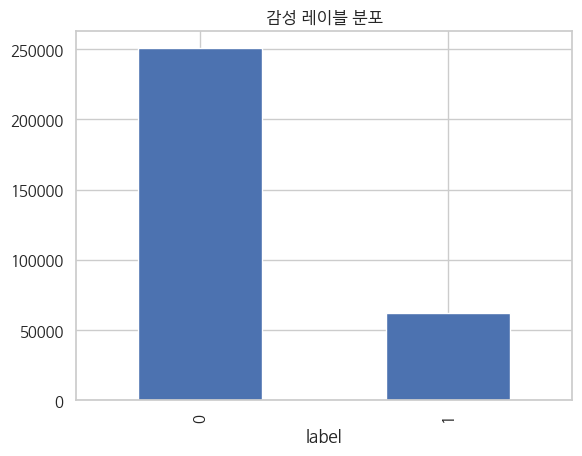

In [120]:
filter_total_df['label'].value_counts().plot(kind='bar')
plt.title('감성 레이블 분포')
plt.show()

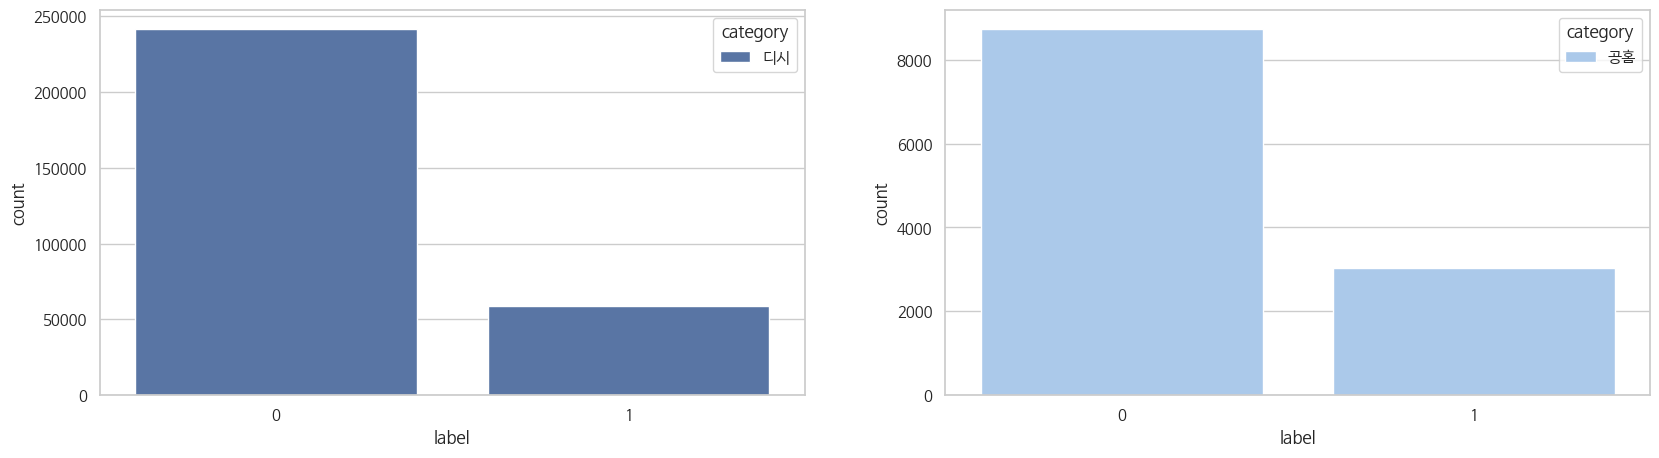

In [121]:
plt.figure(figsize=(20,5))

plt.subplot(121)
sns.countplot(filter_total_df[filter_total_df['category'] == '디시'], 
              x = 'label', 
              hue = 'category')

plt.subplot(122)
sns.countplot(filter_total_df[filter_total_df['category'] == '공홈'], 
              x = 'label', 
              hue = 'category',
              palette= 'pastel')

plt.show()

In [132]:
bad_review['token'].tolist()

['여넨마 이단 퇴마 이렇게 배럭용 으로 만들다 엇 늘다 다 좋다',
 '하필 정화 라 열심히 패 야하다 체인 쓰다 가드 하 랴 좆 같다 뭐 가드 하다 체인 증발 하다 덤 이고 맞딜 이 아예 안되다 걍 플레이 가 좆 같다',
 '옛날 이르다 틀리다 선 존나 자극 하다 런처 각성 이르다 미치다',
 '스킬 이 다 존 나크 고 존나 쎄다 격겜 히든 커맨드 누르다 고르다 캐 같다',
 '걍 템 먹다 다 무기고 등록 하다 되다',
 '태초 악세다 개 에 유니크 개 레전 개 있다 캐 에 유니크 상자 다 떄리다 박다 임',
 '건실 하다 마이 마 돌다 차근차근 매일 조금씩 명성 올리다 맛 이 있다 헬 암만 돌다 안 오르다 슬슬 지치다 네나 같다 사람 많다',
 '웬만하다 패스 만 지르다 다른 건 치다 안 보다 이번 칭오 랑 아바타 는 너무 자다 뽑히다 거 같다 패스 칭 오크 킹덤 첫 구매 칭 오크 이 거 맞다 근데 보주 는 어디서 얻다 되다 안 보이다',
 '애 밉다 시벌 그것 도 모르다 존나 약하다 배럭들 부터 돌리다 버리다 애 밉다',
 '장비 시 뮬 에선 약하다 나오다 던담 에선 쌔지 네 강림 솔 플 하다 생각 하다 장비 시 뮬 믿다 맞다 아니다 걍 덥다 믿다',
 '말다 한테 잡종 인가 벌레 급 인가 꼽 먹음 얼마나 주다 밥 인거 노',
 '남스커 이중 개방 켜 두다 입장 맵 대기 하다 버서커 각 켜 두다 초 입장 하다 진짜 좋다 얼른 막다 네오플 아 본캐 이 거인 놈 들 날 먹다 다',
 '이제 한 달 에 계시 개 딸 깍이다 끝임',
 '고작 이 정도 로 내 가 꺾다 이다 같다 악착같이 버티다',
 '옆 에 있다 콜라보 히든압 은 이벤 압 마냥 너무 짜다 생기다 매물 이 없다',
 '노 인들 내다 돈 에 비 하다 지금 직장 인들 뜯다 살다 이제 아예 보장 을 해달라다 당연하다 혜택 은 내다 사람 만 받다 아니다 하다 국가 에서 보험 마냥 가입자 기준 으로 세팅 을 하다 내야 지 당장 시행 하다 없다 세금 을 빚 내다 먹이다 살리다 하노 저런 애 들 이 자다 징병

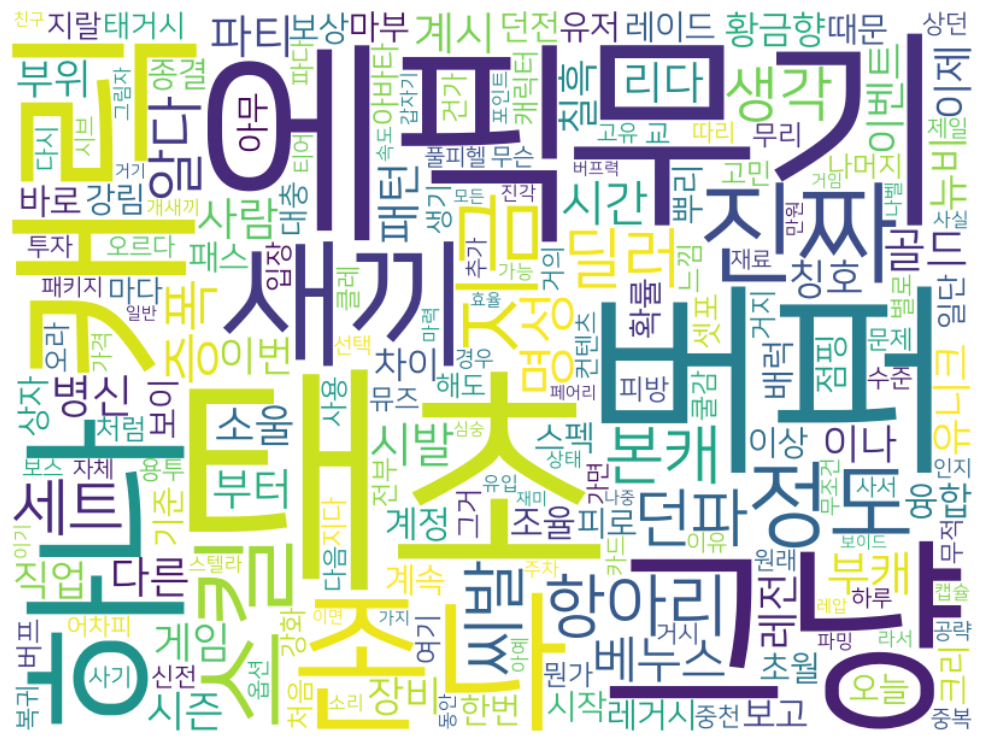

가장 빈번한 명사 10개:
태초: 36994
에픽: 28654
무기: 27556
버퍼: 26027
그냥: 24971
캐릭: 24911
하나: 17921
존나: 17167
새끼: 16887
진짜: 16331


In [144]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from konlpy.tag import Okt  # 한국어 형태소 분석기 추가

# 형태소 분석기 초기화
okt = Okt()

bad_all_tokens = []
bad_nouns_only = []  # 명사만 저장할 리스트

for tokens in bad_review['token'].tolist():
    # 먼저 토큰 분리
    split_tokens = tokens.split()
    bad_all_tokens.extend(split_tokens)
    
    # 각 토큰에서 명사만 추출
    for token in split_tokens:
        nouns = okt.nouns(token)  # 명사 추출
        bad_nouns_only.extend(nouns)  # 명사만 리스트에 추가

# 일반적으로 한 글자 명사는 의미가 약하므로 2글자 이상만 선택 (선택 사항)
bad_nouns_only = [noun for noun in bad_nouns_only if len(noun) > 1]

# 명사의 빈도수 계산 - 변수 이름을 word_counts에서 noun_counts로 변경했습니다
word_counts = Counter(bad_nouns_only)  # 이 변수를 사용해야 합니다

# 워드클라우드 객체 생성 (명사만으로)
wordcloud = WordCloud(
    font_path='NanumSquareR.otf',  # 기존과 동일한 폰트 사용
    width=800, 
    height=600, 
    background_color='white',
    max_font_size=200
).generate_from_frequencies(word_counts)  # noun_counts가 아닌 word_counts 사용

# 워드클라우드 시각화
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout()
plt.savefig('bad_review_nouns_wordcloud.png')  # 파일명 변경
plt.show()

# 가장 빈번한 명사 10개 출력 (확인용)
print("가장 빈번한 명사 10개:")
for noun, count in word_counts.most_common(10):  # noun_counts가 아닌 word_counts 사용
    print(f"{noun}: {count}")

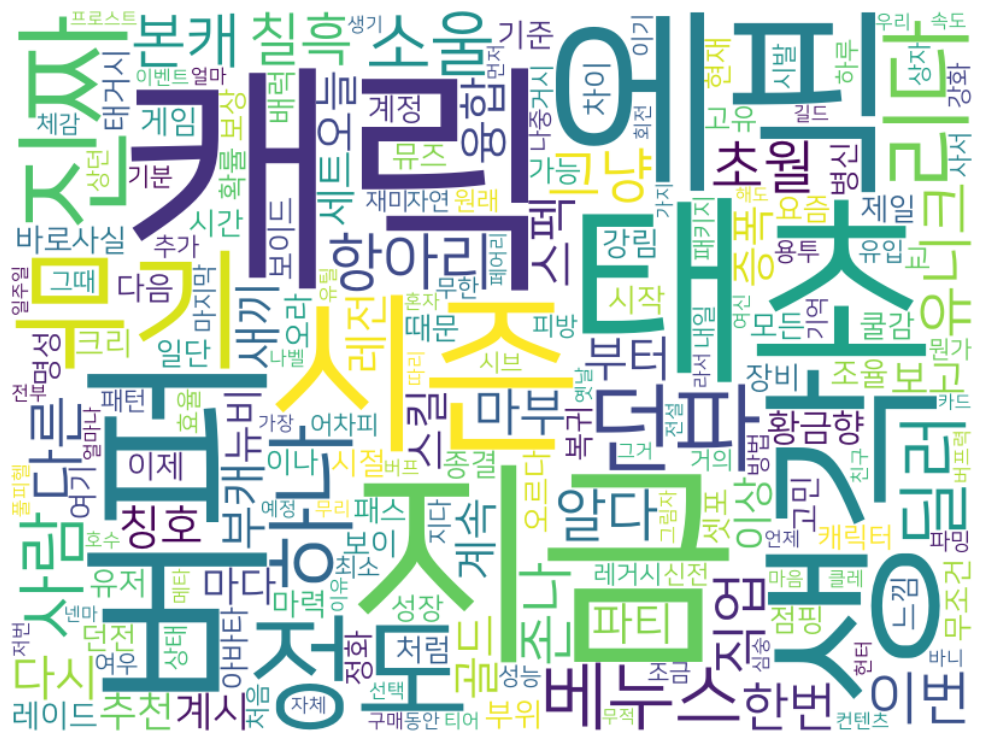

가장 빈번한 명사 10개:
캐릭: 8211
지금: 6462
태초: 5586
버퍼: 5307
에픽: 5251
생각: 4734
시즌: 4427
무기: 3912
정도: 3756
진짜: 3597


In [145]:

# 형태소 분석기 초기화
okt = Okt()

good_all_tokens = []
good_nouns_only = []  # 명사만 저장할 리스트

for tokens in good_reivew['token'].tolist():
    # 먼저 토큰 분리
    split_tokens = tokens.split()
    bad_all_tokens.extend(split_tokens)
    
    # 각 토큰에서 명사만 추출
    for token in split_tokens:
        nouns = okt.nouns(token)  # 명사 추출
        good_nouns_only.extend(nouns)  # 명사만 리스트에 추가

# 일반적으로 한 글자 명사는 의미가 약하므로 2글자 이상만 선택 (선택 사항)
good_nouns_only = [noun for noun in good_nouns_only if len(noun) > 1]

# 명사의 빈도수 계산 - 변수 이름을 word_counts에서 noun_counts로 변경했습니다
word_counts = Counter(good_nouns_only)  # 이 변수를 사용해야 합니다

# 워드클라우드 객체 생성 (명사만으로)
wordcloud = WordCloud(
    font_path='NanumSquareR.otf',  # 기존과 동일한 폰트 사용
    width=800, 
    height=600, 
    background_color='white',
    max_font_size=200
).generate_from_frequencies(word_counts)  # noun_counts가 아닌 word_counts 사용

# 워드클라우드 시각화
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout()
plt.savefig('bad_review_nouns_wordcloud.png')  # 파일명 변경
plt.show()

# 가장 빈번한 명사 10개 출력 (확인용)
print("가장 빈번한 명사 10개:")
for noun, count in word_counts.most_common(10):  # noun_counts가 아닌 word_counts 사용
    print(f"{noun}: {count}")

In [162]:
bad_df = pd.DataFrame({'bad_noun' : bad_nouns_only})
good_df = pd.DataFrame({'good_noun' :good_nouns_only})

In [195]:
top_50_df = bad_df.value_counts().head(50).reset_index()

top_50_df['bad_per(%)'] = top_50_df['count']/sum(bad_df.value_counts())*100

top_50_df['good_noun'] = good_df.value_counts().head(50).reset_index()['good_noun']
top_50_df['good_count'] = good_df.value_counts().head(50).reset_index()['count']

top_50_df['good_per(%)'] = top_50_df['good_count']/sum(good_df.value_counts())*100
top_50_df

,bad_noun,count,bad_per(%),good_noun,good_count,good_per(%)
0,태초,36994,1.400974,캐릭,8211,1.392417
1,에픽,28654,1.085135,지금,6462,1.095823
2,무기,27556,1.043554,태초,5586,0.947271
3,버퍼,26027,0.985650,버퍼,5307,0.899958
4,그냥,24971,0.945659,에픽,5251,0.890462
5,캐릭,24911,0.943387,생각,4734,0.802789
6,하나,17921,0.678674,시즌,4427,0.750728
7,존나,17167,0.650119,무기,3912,0.663395
8,새끼,16887,0.639516,정도,3756,0.636941
9,진짜,16331,0.618460,진짜,3597,0.609977


In [240]:
total_df_bad_sort = bad_df.value_counts().reset_index()
total_df_bad_sort['bad_per(%)'] = total_df_bad_sort['count'] / sum(total_df_bad_sort['count'])*100
total_df_bad_sort['bad_rank'] = total_df_bad_sort['count'].rank(ascending=False)

total_df_good_sort = good_df.value_counts().reset_index()
total_df_good_sort['good_per(%)'] = total_df_good_sort['count'] / sum(total_df_good_sort['count'])*100
total_df_good_sort['good_rank'] = total_df_good_sort['count'].rank(ascending=False)

merge_df_sort = pd.merge(left = total_df_bad_sort, right = total_df_good_sort, left_on = 'bad_noun', right_on = 'good_noun')
merge_df_sort['per_diff'] =  merge_df_sort['bad_per(%)'] - merge_df_sort['good_per(%)']

In [320]:
def search_keyword(keyword) :
    search_df = merge_df_sort[merge_df_sort['bad_noun'] == keyword]
    return search_df

search_keyword('연출')

,bad_noun,count_x,bad_per(%),bad_rank,good_noun,count_y,good_per(%),good_rank,per_diff
1349,연출,296,0.01121,1350.5,연출,67,0.011362,1334.0,-0.000152


In [ ]:
merge_df_sort['per_diff']